In [1]:
import matplotlib.pyplot as plt
from mplsoccer import Pitch, Sbopen, VerticalPitch
import pandas as pd

#open the data 
parser = Sbopen()
df_match = parser.match(competition_id=55, season_id=43)

#Our team of interest 
team = 'Spain'

#get a list of games by our team either home or away 
match_ids = df_match.loc[(df_match["home_team_name"] == team) | (df_match["away_team_name"] == team)]["match_id"].to_list()
match_ids



[3795108, 3795220, 3788762, 3794686, 3788750, 3788775]

### Finding Danger Passes
For this study, we will denote danger passes as the passes 15 seconds before a shot is taken

In [5]:
#create an empty dataframe
danger_passes = pd.DataFrame()

for idx in match_ids:
    #opening the event data from this game 
    df = parser.event(idx)[0]
    for period in [1, 2]:
        #keep only the accurate passes by Spain that are not set pieces 
        mask_pass = (df.team_name == team) & (df.type_name == "Pass") & (df.outcome_name.isnull()) & (df.period == period) & (df.sub_type_name.isnull())
        #keep only the necessary columns for passes
        passes = df.loc[mask_pass, ["x", "y", "end_x", "end_y", "minute", "second", "player_name"]]
        #keep only the shots by Spain that have an xG > 0.07
        mask_shot = (df.team_name == team) & (df.type_name == "Shot") & (df.period == period) & (df.shot_statsbomb_xg > 0.07)
        #keep only the necessary columns for shots
        shots = df.loc[mask_shot, ["minute", "second"]]
        #convert shot time to seconds 
        shot_times = shots['minute']*60 + shots['second']
        shot_window = 15
        #find the starting points for the windows 
        shot_start = shot_times - shot_window
        #condition to avoid negative shot starts
        shot_start = shot_start.apply(lambda i: i if i>0 else (period-1)*45)
        #convert pass time to seconds
        pass_times = passes['minute']*60 + passes['second']
        #check if pass is in any of the windows for this half
        pass_to_shot = pass_times.apply(lambda x: True in ((shot_start < x) & (x < shot_times)).unique())
        #keep only the danger passes
        danger_passes_period = passes.loc[pass_to_shot]
        #concatenate dataframe with a previous one to keep danger passes for the whole tournament 
        danger_passes = pd.concat([danger_passes, danger_passes_period], ignore_index=True)


<function matplotlib.pyplot.show(close=None, block=None)>

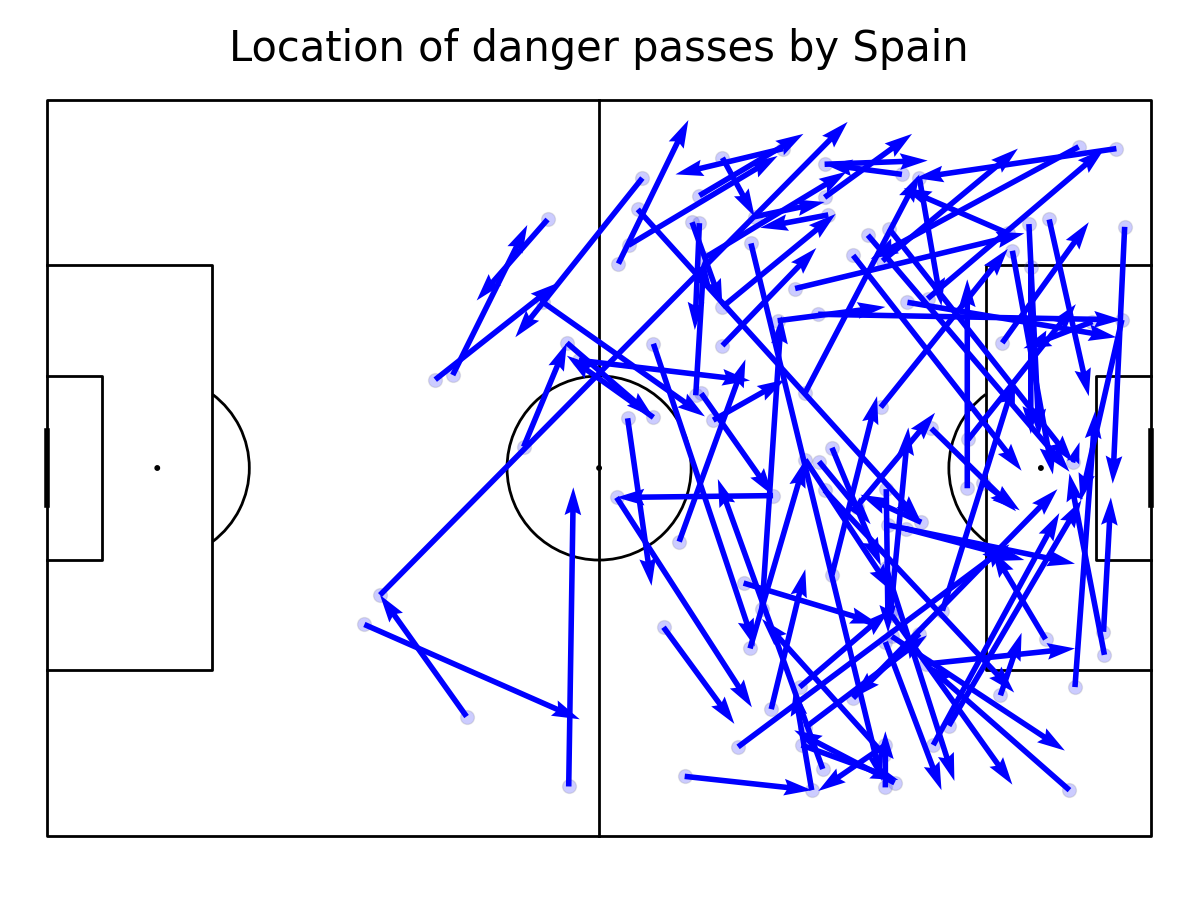

In [10]:
#plot pitch 
pitch = Pitch(line_color='black')
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
#scatter the location on the pitch 
pitch.scatter(danger_passes.x, danger_passes.y, s=100, color='blue', edgecolors='grey', linewidth=1, alpha=0.2, ax=ax["pitch"])
pitch.arrows(danger_passes.x, danger_passes.y, danger_passes.end_x, danger_passes.end_y, color = "blue", ax=ax['pitch'])
#add the title 
fig.suptitle('Location of danger passes by ' + team, fontsize=30)
plt.show

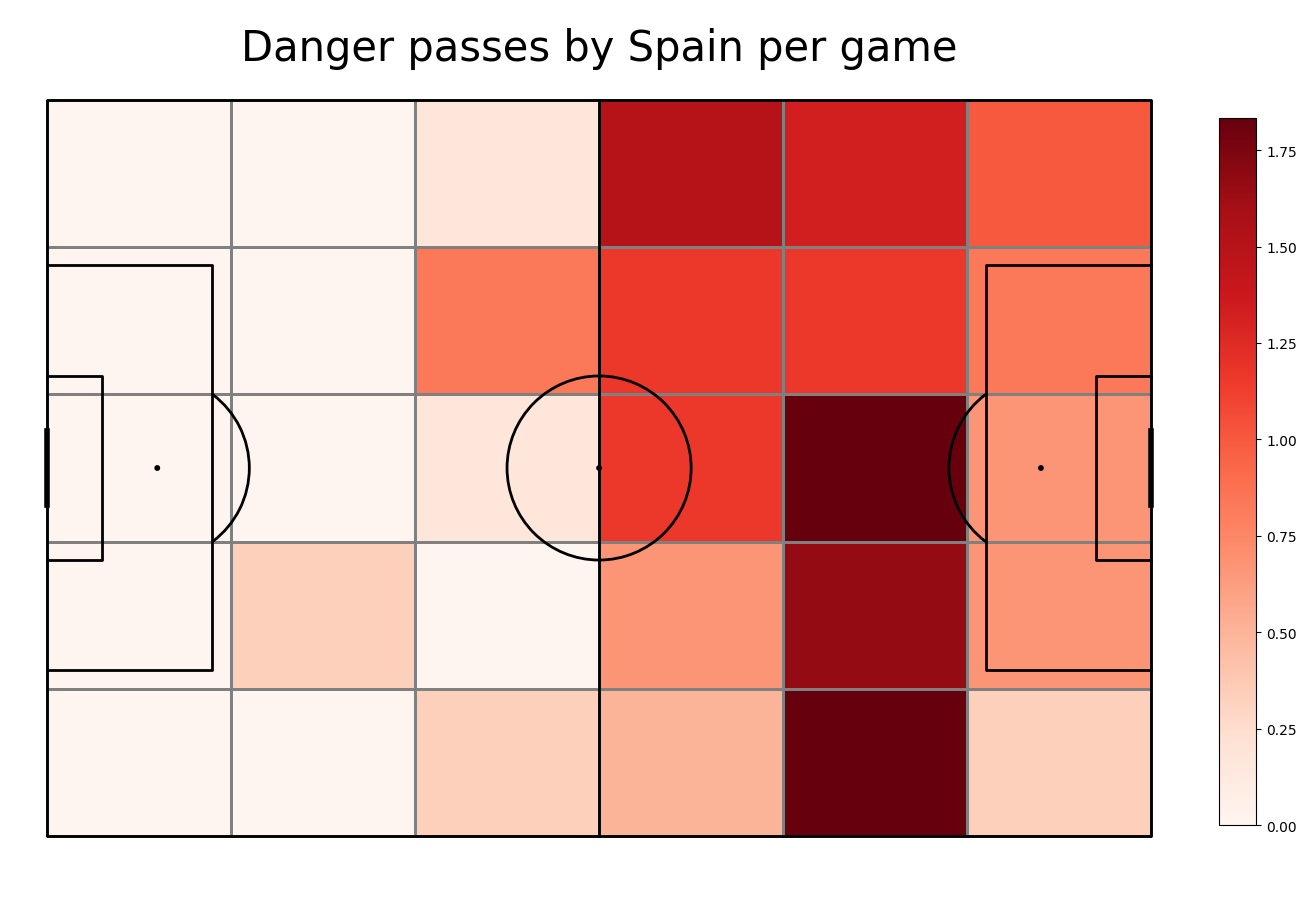

In [11]:
#plot vertical pitch
pitch = Pitch(line_zorder=2, line_color='black')
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
#get the 2D histogram
bin_statistic = pitch.bin_statistic(danger_passes.x, danger_passes.y, statistic='count', bins=(6, 5), normalize=False)
#normalize by number of games
bin_statistic["statistic"] = bin_statistic["statistic"]/6
#make a heatmap
pcm  = pitch.heatmap(bin_statistic, cmap='Reds', edgecolor='grey', ax=ax['pitch'])
#legend to our plot
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Danger passes by ' + team + " per game", fontsize = 30)
plt.show()

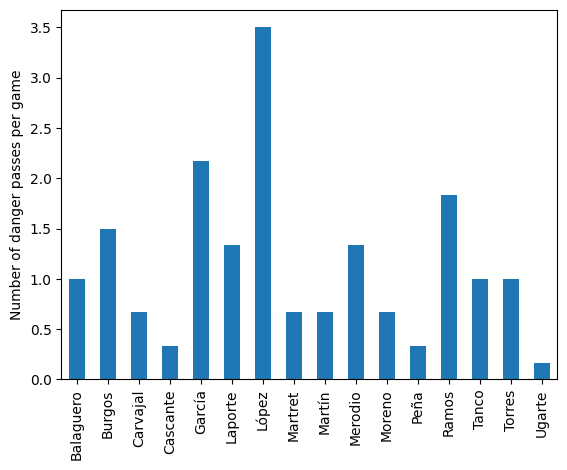

In [12]:
#keep only surnames
danger_passes["player_name"] = danger_passes["player_name"].apply(lambda x: str(x).split()[-1])
#count passes by player and normalize them
pass_count = danger_passes.groupby(["player_name"]).x.count()/6
#make a histogram
ax = pass_count.plot.bar(pass_count)
#make legend
ax.set_xlabel("")
ax.set_ylabel("Number of danger passes per game")
plt.show()
